# Homework 7 Template

Rixin Li & G . Besla



In [ ]:
 # Make edits where instructed - look for "****", which indicates where you need to add code. 

In [1]:
from os.path import join
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass as COM

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import component_mass

data_dir = '/home/wxs0703/astr400b/'

# M33AnalyticOrbit

In [31]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """
        Arguments:
            filename: str, file to store integrated orbit
        """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.outfile = filename
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        COM_M33 = COM(join(data_dir, 'M33_000.txt'), 2)
        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        M33_p = COM_M33.COM_P()
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        M33_v = COM_M33.COM_V(*M33_p).value
        M33_p = M33_p.value
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        COM_M31 = COM(join(data_dir, 'M31_000.txt'), 2)
        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        M31_p = COM_M31.COM_P()
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        M31_v = COM_M31.COM_V(*M31_p).value
        M31_p = M31_p.value
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = M33_p - M31_p
        self.v0 = M33_v - M31_v
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = 0.12e12
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1
        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = 0.019e12
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 61.5
        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = 1.921e12
    
    
    def HernquistAccel(self, M, r_a, r): # it is easiest if you take as an input the position VECTOR 
        """
        Calculates the gravitational acceleration from a Hernquist profile
        
        Arguments:
            M: float, halo or bulge mass
            r_a: float, scale length corresponding to type
            r: np.array, relative position vector
            
        Returns:
            Hern: float, hernquist acceleration vector
        """
        
        ### **** Store the magnitude of the position vector
        rmag = np.linalg.norm(r)
        
        ### *** Store the Acceleration
        Hern =  -self.G*M/(rmag *(r_a + rmag)**2) * r
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self, M, r_d, r):# it is easiest if you take as an input a position VECTOR  r 
        """
        Calculates the disk acceleration using the Miyamoto-Nagai profile.
        
        Arguments:
            M: float, mass of the disk
            r_d: float, scale radius of the disk
            r: np.array, relative position vector
        
        Returns:
            a_MN: Miyamoto-Nagai acceleration vector
        """
        
        ### Acceleration **** follow the formula in the HW instructions
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        #  multiply the whle thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction
        R = np.sqrt(r[0]**2 + r[1]**2)
        z_d = r_d/5.0
        B = r_d + np.sqrt(r[2]**2 + z_d**2)
        
        a_MN = -self.G*M/(R**2 + B**2)**1.5 * r * np.array([1,1,B/np.sqrt(r[2]**2 + z_d**2)])
    
        return a_MN
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r): # input should include the position vector, r
        """
        Calculates the acceleration due to M31.
        
        Arguments:
            r: np.array, relative position vector
            
        Returns:
            a_tot: np.array, total acceleration
        """

        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        a_halo = self.HernquistAccel(self.Mhalo, self.rhalo, self.r0)
        a_bulge = self.HernquistAccel(self.Mbulge, self.rbulge, self.r0)
        a_disk = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, self.r0)
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        a_tot = a_halo + a_bulge + a_disk
        return a_tot
    
    
    def LeapFrog(self, dt, r, v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """
        Implements the Leapfrog integration routine
        """
        
        # predict the position at the next half timestep
        rhalf = r + v*dt/2
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf)*dt
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + 0.5*(vnew)*dt
        
        return rnew, vnew
    
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """
        Computes the future orbit of M33
        """

        # initialize the time to the input starting time
        t = t0

        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+2, 7), dtype=float)

        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        r0 = self.r0
        v0 = self.v0

        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1

        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t < tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t += dt
            # **** store the new time in the first column of the ith row
            orbit[i, 0] = t

            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            r, v = self.LeapFrog(dt, r0, v0)

            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            orbit[i, 1:4] = r
            orbit[i, 4:] = v

            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            r0, v0 = r, v

            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i += 1
        
        
        # write the data to a file
        np.savetxt(self.outfile, orbit, fmt = "%12.3f"*7, comments='#', 
                   header="{:>10s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}{:>12s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

        # there is no return function



In [32]:
M33Orb = M33AnalyticOrbit('M33_orbit.txt')

In [33]:
M33Orb.OrbitIntegration(0, 0.1, 10)

In [34]:
orbit = np.genfromtxt('M33_orbit.txt', names=True)

In [35]:
r = np.sqrt(orbit['x']**2 + orbit['y']**2 + orbit['z']**2)
t = orbit['t']

In [7]:
# Read in the data files for the orbits of each galaxy
MW = np.genfromtxt('Orbit_MW.txt', dtype=None, names=True)
M31 = np.genfromtxt('Orbit_M31.txt', dtype=None, names=True)
M33 = np.genfromtxt('Orbit_M33.txt', dtype=None, names=True)

In [8]:
# function to compute the magnitude of the difference between two vectors 
vecdiff = lambda v1, v2: np.linalg.norm(v1-v2, axis=1)

In [9]:
# Determine the magnitude of the relative position and velocities 
t_sim = MW['t']

# of M33 and M31
dist_M33_M31 = vecdiff(np.transpose(np.vstack((M33['x'], M33['y'], M33['z']))),
                       np.transpose(np.vstack((M31['x'], M31['y'], M31['z']))))
vel_M33_M31 = vecdiff(np.transpose(np.vstack((M33['vx'], M33['vy'], M33['vz']))),
                      np.transpose(np.vstack((M31['vx'], M31['vy'], M31['vz']))))

In [11]:
print(dist_M33_M31[0], r[0])

201.1212144454185 201.08279712596


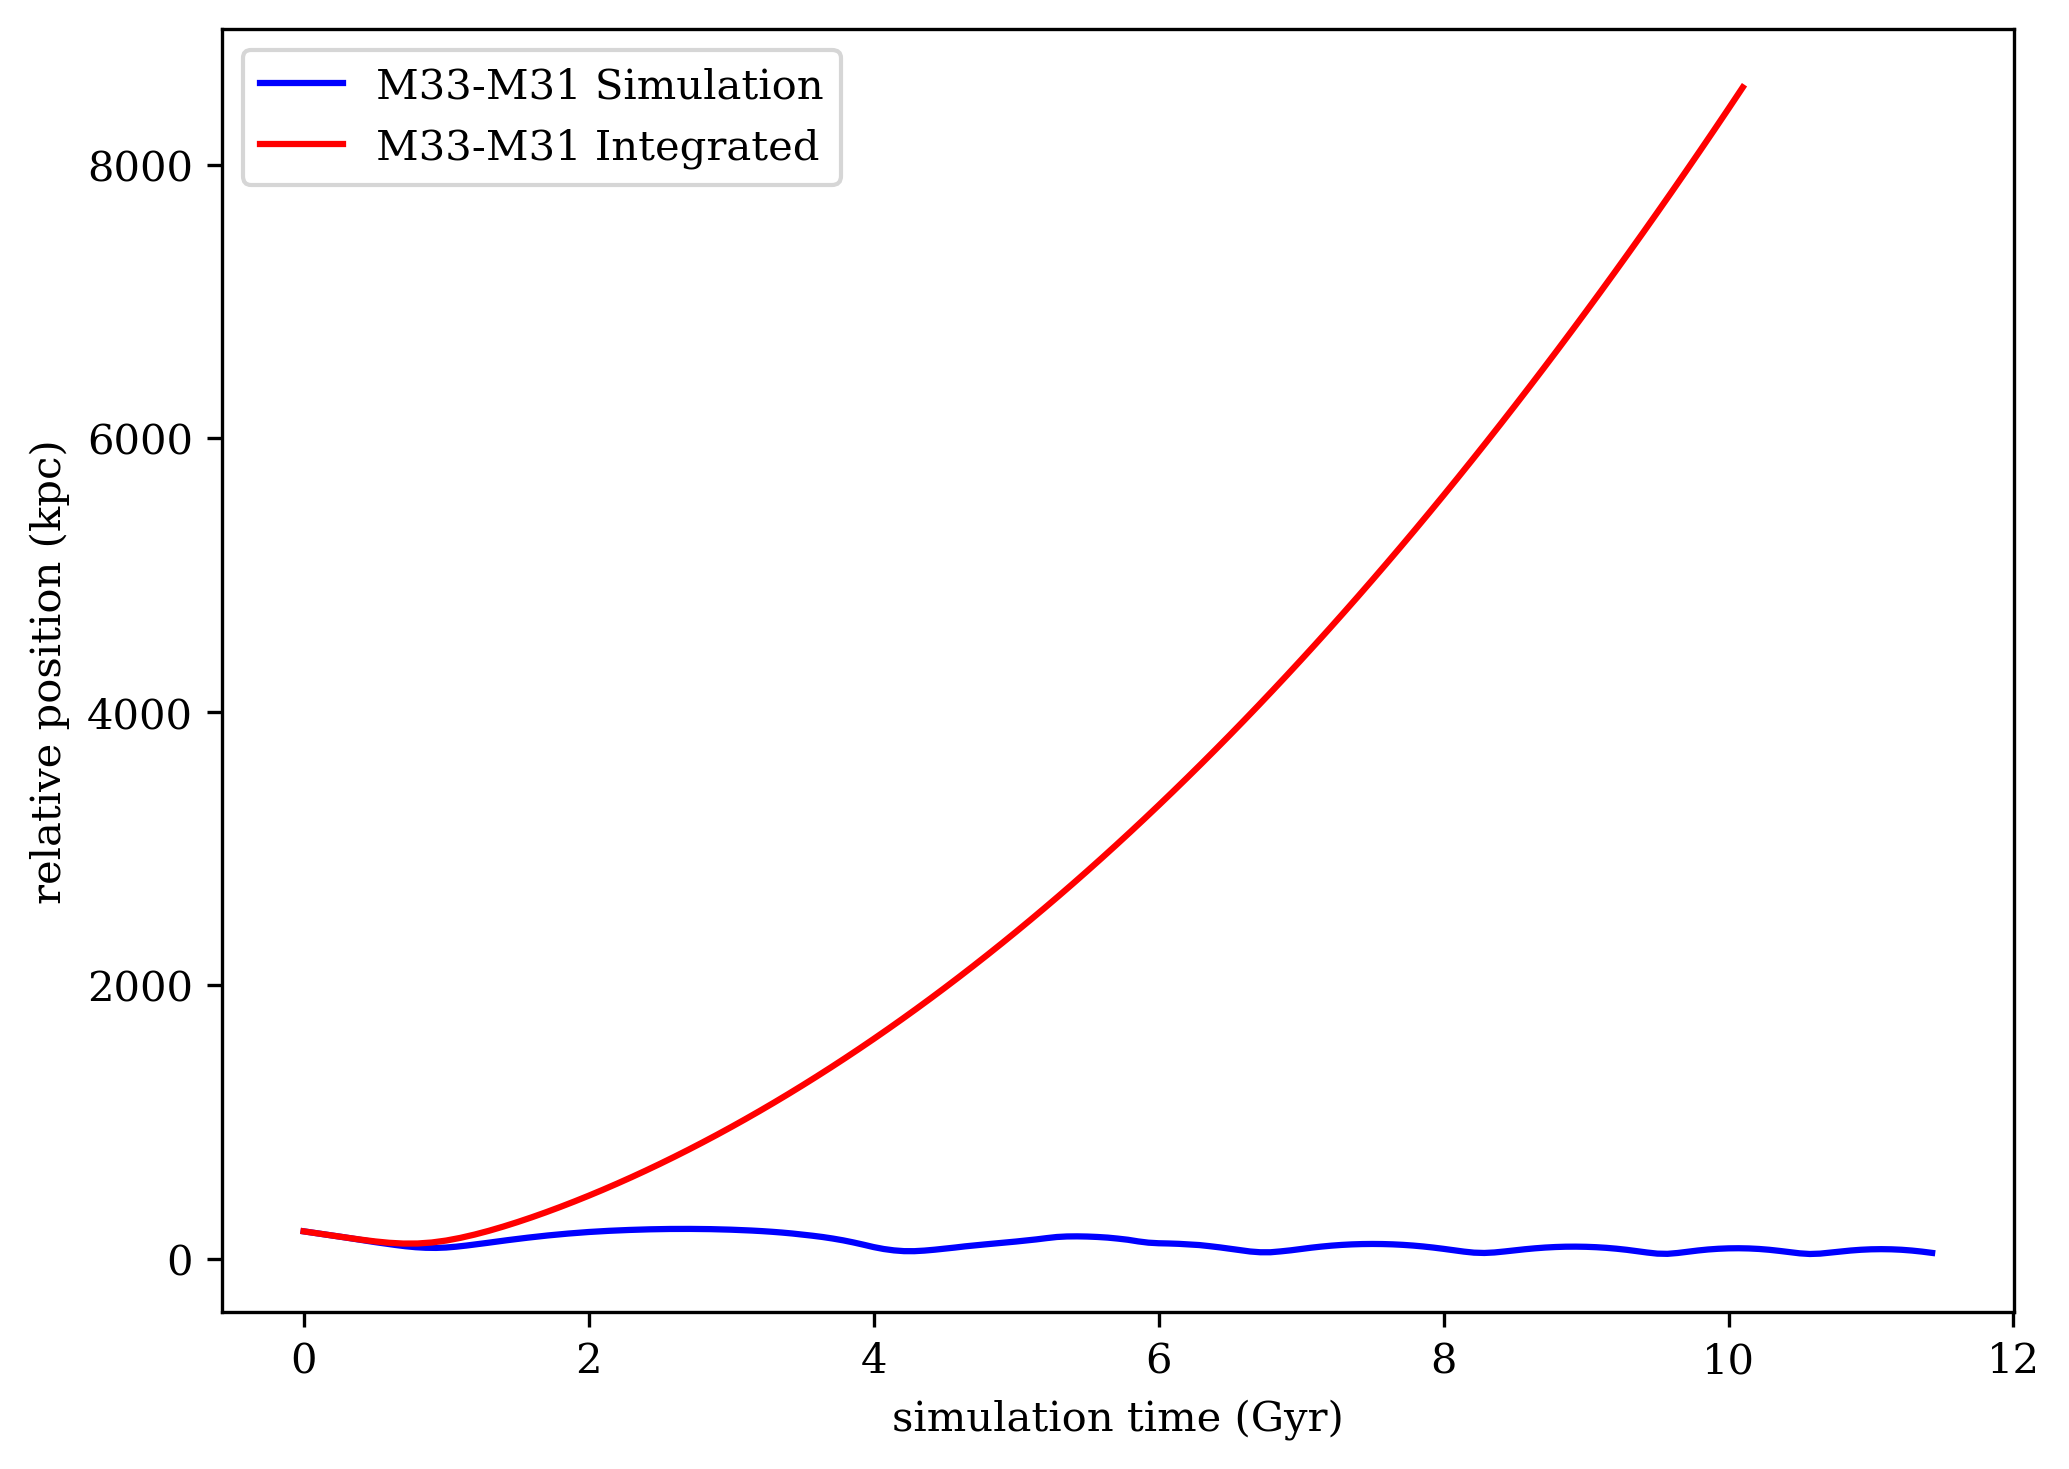

In [36]:
# Plot the Orbit of the galaxies 
#################################
plt.rcParams.update({"font.family": "serif", "figure.dpi": 300})

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot()
ax.plot(t_sim, dist_M33_M31, c='blue', label='M33-M31 Simulation')
ax.plot(t, r, c='red', label='M33-M31 Integrated')
ax.set_xlabel('simulation time (Gyr)')
ax.set_ylabel('relative position (kpc)')
ax.legend()

plt.tight_layout()
plt.savefig('orbit_M33_M31.jpg')

#### Questions

2. The integrated plot diverges from the simulation after around 1 Gyr. 

3. This could be due to several factors, such as not including MW, not considering tidal effects as M33 gets close to M31, and not considering angular momentum transfer.

4. To include MW, we simply need to add the acceleration from MW at every step of the integration. Specifically, we would initialize MW position and velocity over time, calculate its relative position and velocity with M33, and add another function MWAccel that does the same thing as M31Accel but for MW.